# Question to be answered:

- Is the accuracy of model/human significantly better? In both force and mass questions?
- Is the distribution of responses significantly different?

In [1]:
import isaac.constants
isaac.constants.TQDM_DISABLE = True

from torch import nn
from torch.nn import Softmax
from isaac.utils import get_cuda_device_if_available
import joblib

from isaac.dataset import read_dataset, prepare_dataset
from isaac.models import MultiBranchModel, ComplexRNNModel
from isaac.constants import BASIC_TRAINING_COLS, MASS_CLASS_COLS, FORCE_CLASS_COLS
from isaac.evaluation import evaluate_saved_model
from isaac.statistical_tests import z_test

import torch
import glob
from torch.autograd import Variable
import numpy as np
import pandas as pd
from tqdm import tqdm


In [2]:
INTERVAL_SIZE = 1
FPS = 60
STEP_SIZE = 3
PD_STEP_SIZE = 10

In [3]:
device = get_cuda_device_if_available()
print(device)

cpu


In [4]:
trials = read_dataset("../new_exp_data/exp7_passive.h5")

In [5]:
class Seq2SeqRNNModel(MultiBranchModel):
    def __init__(self, args):
        super(Seq2SeqRNNModel, self).__init__(*args)
    
    def predict_seq2seq_in_intervals(self, x):
        
        output_seq1 = None
        output_seq2 = None
        
        frames_per_interval = INTERVAL_SIZE * FPS // STEP_SIZE
        
        for i in range(0, x.shape[1], frames_per_interval):
                        
            out, _ = self.base_gru(x[:, i:i+frames_per_interval, :])

            out_1, _ = self.gru1(out)
            out_1 = self.fc1(out_1)[:, -1:, :]

            out_2, _ = self.gru2(out)
            out_2 = self.fc2(out_2)[:, -1:, :]
            
            if output_seq1 is None:
                output_seq1 = out_1
                output_seq2 = out_2
            else:
                output_seq1 = torch.cat([output_seq1, out_1], dim=1)
                output_seq2 = torch.cat([output_seq2, out_2], dim=1)
            
        return output_seq1, output_seq2
    
    def predict_seq2seq(self, x):
        out, _ = self.base_gru(x)

        out_1, _ = self.gru1(out)
        out_1 = self.fc1(out_1)

        out_2, _ = self.gru2(out)
        out_2 = self.fc2(out_2)
        
        return out_1, out_2

In [6]:
def predict_(model, val_loader, seq_start=None, seq_end=None, step_size=None):

    for i, (x_val, y_val) in enumerate(val_loader):
        x_val = Variable(x_val[:, seq_start:seq_end:step_size, :])
        y_hat = model.predict_seq2seq_in_intervals(x_val)

        if i == 0:
            all_predictions = y_hat
        else:
            all_predictions = torch.cat([all_predictions, y_hat], dim=0)

    return all_predictions


def predict_with_saved_model(model_path, network_dims, test_dataset_path, training_columns, class_columns, 
                             seq_start=None, seq_end=None, step_size=None, scaler_path=None, trials=None, 
                             arch=ComplexRNNModel, multiclass=False, categorical_columns=(), 
                             normalisation_cols=(), device=torch.device("cpu"), return_test_loader=False):
    
    class_columns = list(class_columns)
    training_columns = list(training_columns)

    if scaler_path:
        scaler = joblib.load(scaler_path)
        normalise_data=True
    else:
        scaler = None
        normalise_data=False

    model = arch(network_dims)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model = model.to(device=device)
    model.eval()

    if trials is None:
        trials = read_dataset(test_dataset_path)

    test_loader, _ = prepare_dataset([trials], class_columns, normalise_data=normalise_data,
                                     scaler=scaler, training_columns=training_columns, multiclass=multiclass,
                                     categorical_columns=categorical_columns, normalisation_cols=normalisation_cols,
                                     device=device)

    return predict_(model, test_loader, seq_start=seq_start, step_size=step_size, seq_end=seq_end)


def get_question_predictions_for_group_of_models(question_type):
    normalise_data = True
    scaler_path = "scalers/passive_dual_scaler.sk"
    network_dims = (len(BASIC_TRAINING_COLS), 25, 3, 0.5)
    dataset_path = "../new_exp_data/exp7_passive.h5"
    class_columns = [list(MASS_CLASS_COLS), list(FORCE_CLASS_COLS)]
    multiclass = True
    seq_end = 2700
    step_size = STEP_SIZE
    
    models = sorted(glob.glob("models/train_25_mb/best_"+question_type+"_model_seed_*.pt"))

    group_predictions = []
    
    for model_path in tqdm(models):
        predicted = predict_with_saved_model(model_path, network_dims, dataset_path, 
                                             training_columns=BASIC_TRAINING_COLS, 
                                             class_columns=class_columns, step_size=step_size, 
                                             seq_end=seq_end, scaler_path=scaler_path,
                                             arch=Seq2SeqRNNModel, multiclass=multiclass, trials=None)

        if question_type == "mass":
            predicted = predicted[0]
        else:
            predicted = predicted[1]

        group_predictions.append(predicted.detach())

    return torch.stack(group_predictions)

def get_participant_accuracy(passive_responses, answer_column, question_type_answer):
    return [(df[answer_column] == df[question_type_answer]).sum() / len(df) 
            for _, df in passive_responses.groupby("cond_worldvar")]

def get_participant_accuracy_filtering_by_answer(passive_responses, answer_column, question_type_answer, filter_by_class):
    
    passive_responses = passive_responses.copy().query(question_type_answer+" == "+filter_by_class)
    
    return [(df[answer_column] == df[question_type_answer]).sum() / len(df) 
            for _, df in passive_responses.groupby("cond_worldvar")]

# T-test for MASS questions

## Load model's predictions

In [7]:
print("MASS")
question_type = "mass"
group_mass_prediction = get_question_predictions_for_group_of_models(question_type)
     
print("\nFORCE")
question_type = "force"
group_force_prediction = get_question_predictions_for_group_of_models(question_type)

  0%|          | 0/25 [00:00<?, ?it/s]

MASS


  0%|          | 0/25 [00:00<?, ?it/s]


FORCE


100%|██████████| 25/25 [00:21<00:00,  1.16it/s]


In [8]:
s = Softmax(dim=-1)
group_force_prediction = s(group_force_prediction)
group_mass_prediction = s(group_mass_prediction)

In [9]:
mean_force_prediction = group_force_prediction.mean(dim=0)
mean_mass_prediction = group_mass_prediction.mean(dim=0)

In [10]:
mean_force_prediction.shape

torch.Size([36, 45, 3])

In [11]:
import matplotlib.pyplot as plt

In [12]:
def get_trial_dataframes(mass_predictions, force_predictions):
    all_trials = []
    
    for mass_trial_predictions, force_trial_predictions in zip(mass_predictions, force_predictions):
        
        rnn_class_columns = ["rnn_" + cl for cl in list(MASS_CLASS_COLS) + list(FORCE_CLASS_COLS)]
        all_predictions = torch.cat((mass_trial_predictions, force_trial_predictions), dim=1).numpy()
        trial_df = pd.DataFrame(all_predictions, columns=rnn_class_columns)
        all_trials.append(trial_df)
    
    return all_trials

In [13]:
all_trials = get_trial_dataframes(mean_mass_prediction, mean_force_prediction)

In [14]:
import json

In [15]:
condition_world_variant = []
world_id = []

for condition_id in range(1, 5):
    filename = "../new_exp_data/physics_data%d.json" % condition_id
    fd = open(filename)
    sim_data = json.load(fd)
    
    for sim in sim_data:
        if sim["practice"]:
            continue
        condition_world_variant.append(sim["condition_world_variant"])
        world_id.append(sim["world_id"])

In [16]:
for trial, cwv, w_id in zip(all_trials, condition_world_variant, world_id):
    trial["condition_world_variant"] = cwv
    trial["world_id"] = w_id

## Load human results

In [17]:
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 1: 
  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: In value[[3L]](cond) :
  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
 
  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  "getThreads" not available for .C() for package "RevoUtilsMath"

  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2: 
  warnings.warn(x, RRuntimeWa

In [18]:
rdata_path = "../new_exp_data/e7_passive_io_rtheta.rdata"
r['load'](rdata_path)

responses = r["tw"].query("practice == 0")
responses.trial_type = responses.trial_type.astype(int)
responses.world_id = responses.world_id.astype(int)

/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [19]:
responses[['post_ent_mass.rtheta', 'post_ent_rel.rtheta']].head()

,post_ent_mass.rtheta,post_ent_rel.rtheta
2,0.175401,0.923305
3,0.068594,1.336480
4,0.035370,1.524994
5,0.037586,1.480245
6,0.067509,1.395219


In [20]:
for trial in all_trials:
    this_trial_responses = responses[responses.world_id == trial.world_id.unique()[0]]
    
    assert this_trial_responses.true_mass.nunique() == 1
    assert this_trial_responses.true_rel.nunique() == 1
    assert this_trial_responses["post_ent_mass.rtheta"].nunique() == 1
    assert this_trial_responses["post_ent_rel.rtheta"].nunique() == 1
    
    trial["true_rel"] = this_trial_responses.true_rel.unique()[0]
    trial["true_mass"] = this_trial_responses.true_mass.unique()[0]
    trial["post_ent_mass"] = this_trial_responses["post_ent_mass.rtheta"].unique()[0]
    trial["post_ent_rel"] = this_trial_responses["post_ent_mass.rtheta"].unique()[0]

for trial in all_trials:
    trial[['rnn_A', 'rnn_B', 'rnn_same']].plot(title=trial.true_mass.unique()[0])
    trial[['rnn_attract', 'rnn_none', 'rnn_repel']].plot(title=trial.true_rel.unique()[0])
    plt.show()
    print("------------------------------------------------------------------")

In [21]:
def entropy_response_rnn(responses):
    return -np.sum(responses * np.log2(responses), axis=1)

all_answers = pd.read_hdf("../new_exp_data/rnn_answers_with_counts.h5", key="key")

In [22]:
max_entropy = entropy_response_rnn(np.array([[1/3, 1/3, 1/3]]))

for i, trial in enumerate(all_trials):
    trial["mass_entropy"] = entropy_response_rnn(trial[['rnn_A', 'rnn_B', 'rnn_same']].values)
    trial["force_entropy"] = entropy_response_rnn(trial[['rnn_attract', 'rnn_none', 'rnn_repel']].values)
    trial["mass_entropy_reduction"] = (max_entropy - trial.mass_entropy)
    trial["force_entropy_reduction"] = (max_entropy - trial.force_entropy)
    
    trial["rnn_mass_majority_choice"] = all_answers.model_first_mass_resp.iloc[i]
    trial["rnn_force_majority_choice"] = all_answers.model_first_rel_resp.iloc[i]

In [23]:
import glob
trials_pd_paths = sorted(glob.glob("../new_exp_data/pd_summaries/pd_summaries/cv*tt*.rdata"))

trial_pds = []

for path in trials_pd_paths:
    r['load'](path)
    trial = r['df.ext']
    trial.frame = np.arange(10, 2710, 10).tolist() * 4
    trial_pds.append(trial)    

/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [24]:
correlation_dfs = []

for trial_pd, rnn_trial in zip(trial_pds, all_trials):
    
    window_size = int(FPS * INTERVAL_SIZE / PD_STEP_SIZE)
    pd_mass = trial_pd[["frame", "pd.mass.rtheta"]].groupby("frame").agg({"pd.mass.rtheta": np.mean})
    pd_mass = pd_mass["pd.mass.rtheta"].rolling(window=window_size).sum().values[window_size-1::window_size]

    pd_force = trial_pd[["frame", "pd.rel.rtheta"]].groupby("frame").agg({"pd.rel.rtheta": np.mean})
    pd_force = pd_force["pd.rel.rtheta"].rolling(window=window_size).sum().values[window_size-1::window_size]
    
    rnn_mass_entropy_reduction = rnn_trial["mass_entropy_reduction"].values
    # rnn_mass_entropy_reduction = (rnn_mass_entropy_reduction - rnn_mass_entropy_reduction.shift().fillna(0)).values
    
    rnn_force_entropy_reduction = rnn_trial["force_entropy_reduction"].values
    # rnn_force_entropy_reduction = (rnn_force_entropy_reduction - rnn_force_entropy_reduction.shift().fillna(0)).values
    
    force_class = rnn_trial.true_rel.unique()[0]
    force_class_id = FORCE_CLASS_COLS.index(force_class)
    mass_class = rnn_trial.true_mass.unique()[0]
    mass_class_id = MASS_CLASS_COLS.index(mass_class)
    
    df = pd.DataFrame(columns=["second", "pd_mass", "pd_force", "mass_entropy_reduction", "force_entropy_reduction",
                               "mass_corr", "force_corr"])
    df.pd_mass = pd_mass / pd_mass.max()
    df.pd_force = pd_force / pd_force.max()
    df.mass_entropy_reduction = rnn_mass_entropy_reduction / rnn_mass_entropy_reduction.max()
    df.force_entropy_reduction = rnn_force_entropy_reduction / rnn_force_entropy_reduction.max()
    df.true_rel = force_class
    df.true_mass = mass_class
    df.rnn_mass_answer = rnn_trial.rnn_mass_majority_choice.unique()[0]
    df.rnn_force_answer = rnn_trial.rnn_force_majority_choice.unique()[0]
    df.is_mass_correct = df.rnn_mass_answer == df.true_mass
    df.is_force_correct = df.rnn_force_answer == df.true_rel
    
    df.second = np.arange(INTERVAL_SIZE, 45+INTERVAL_SIZE, INTERVAL_SIZE)
    df.set_index("second", inplace=True)
    
    # .rolling(window=ws).sum()[ws-1:]
    ws = 1
    df.mass_corr = np.corrcoef(df.pd_mass.rolling(window=ws).sum()[ws-1:], 
                               df.mass_entropy_reduction.rolling(window=ws).sum()[ws-1:])[0][1]
    df.force_corr = np.corrcoef(df.pd_force.rolling(window=ws).sum()[ws-1:],
                                df.force_entropy_reduction.rolling(window=ws).sum()[ws-1:])[0][1]
    
    correlation_dfs.append(df)

    
    """plt.plot(df.force_entropy_reduction.rolling(window=ws).mean(), label="RNN")
    plt.plot(df.pd_force.rolling(window=ws).mean(), label="PD force")
    plt.xticks(df.index)
    plt.grid()
    plt.title(force_class + " " + str(force_corr))
    plt.legend()
    plt.show()
    
    plt.plot(df.mass_entropy_reduction, label="RNN")
    plt.plot(df.pd_mass, label="PD force")
    plt.title(mass_class + " " + str(mass_corr))
    plt.legend()
    plt.show()
    
    print("----------------------------------------------")"""

In [25]:
corr_df = [[df.true_mass, df.mass_corr.unique()[0], df.is_mass_correct, 
            df.true_rel, df.force_corr.unique()[0], df.is_force_correct] for df in correlation_dfs]

corr_df = pd.DataFrame(data=corr_df, columns=["true_mass", "mass_corr", "is_mass_correct", 
                                              "true_rel", "force_corr", "is_force_correct"])

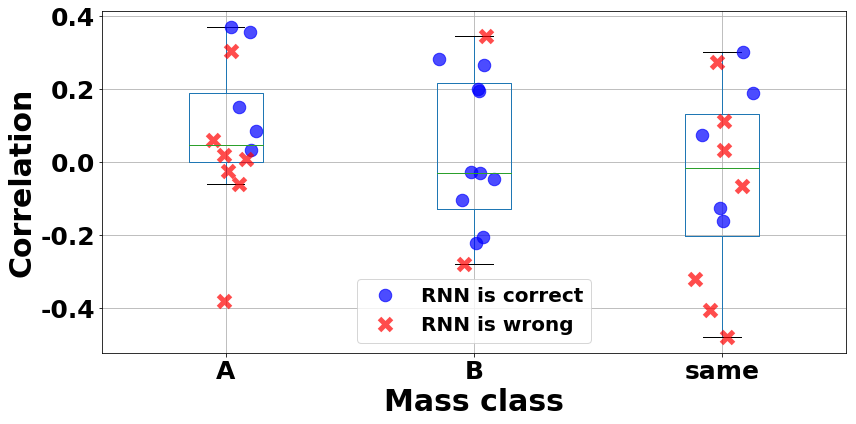

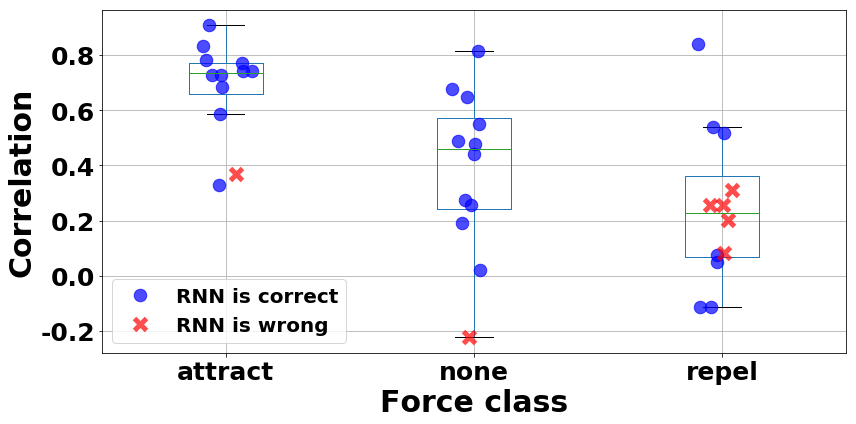

In [26]:
axes = corr_df.boxplot(column="mass_corr", by="true_mass", showfliers=False, figsize=(12, 6))
axes.get_figure().suptitle("")
plt.title("")
plt.ylabel("Correlation", fontsize=30, fontweight="bold")
plt.xlabel("Mass class", fontsize=30, fontweight="bold")
plt.tick_params(axis='both', labelsize=25)

axes.set_xticklabels(MASS_CLASS_COLS, fontweight='bold')
axes.set_yticks(np.arange(-4, 5, 2) / 10)
axes.set_yticklabels(np.arange(-4, 5, 2) / 10, fontweight='bold')

label = ""
for i in range(1, 4):
    if i == 3:
        label = "RNN is correct"
    
    y = corr_df.mass_corr[(corr_df.true_mass == MASS_CLASS_COLS[i - 1]) & (corr_df.is_mass_correct)]
    x = np.random.normal(i, 0.055, size=len(y))
    plt.plot(x, y, 'b.', alpha=0.7, label=label, markersize=25)
    
    if i == 3:
        label = "RNN is wrong"
    
    y = corr_df.mass_corr[(corr_df.true_mass == MASS_CLASS_COLS[i - 1]) & (~corr_df.is_mass_correct)]
    x = np.random.normal(i, 0.055, size=len(y))
    plt.plot(x, y, 'rx', alpha=0.7, label=label, markersize=12, mew=5)
    
plt.legend(fontsize=25, prop={'size': 20, 'weight':'bold'})
plt.tight_layout()
plt.savefig("cogsci_images/mass_corr_PD.pdf")
plt.savefig("cogsci_images/mass_corr_PD.jpg")
    
    
axes = corr_df.boxplot(column="force_corr", by="true_rel", showfliers=False, figsize=(12, 6))
axes.get_figure().suptitle("")
plt.title("")
plt.ylabel("Correlation", fontsize=30, fontweight="bold")
plt.xlabel("Force class", fontsize=30, fontweight="bold")
plt.tick_params(axis='both', labelsize=25)

axes.set_xticklabels(FORCE_CLASS_COLS, fontweight='bold')
axes.set_yticks(np.arange(-2, 10, 2) / 10)
axes.set_yticklabels(np.arange(-2, 10, 2) / 10, fontweight='bold')


label = ""
for i in range(1, 4):
    if i == 3:
        label = "RNN is correct"
    
    y = corr_df.force_corr[(corr_df.true_rel == FORCE_CLASS_COLS[i - 1]) & (corr_df.is_force_correct)]
    x = np.random.normal(i, 0.055, size=len(y))
    plt.plot(x, y, 'b.', alpha=0.7, label=label, markersize=25)
    
    if i == 3:
        label = "RNN is wrong"
    
    y = corr_df.force_corr[(corr_df.true_rel == FORCE_CLASS_COLS[i - 1]) & (~corr_df.is_force_correct)]
    x = np.random.normal(i, 0.055, size=len(y))
    plt.plot(x, y, 'rx', alpha=0.7, label=label, markersize=12, mew=5)

plt.legend(fontsize=25, prop={'size': 20, 'weight':'bold'})
plt.tight_layout()
plt.savefig("cogsci_images/force_corr_PD.pdf")
plt.savefig("cogsci_images/force_corr_PD.jpg")

In [27]:
from isaac.visualization import make_frame_curried
import moviepy.editor as mpy

def make_clip(trial_data):

    duration = len(trial_data)

    n_bodies = sum(["o"+str(i)+".x" in list(trial_data.columns) for i in range(1, 5)])
    
    while (len(trial_data) + 1) % 60 != 0:
        trial_data = trial_data.append(trial_data.iloc[-1], ignore_index=True)
    make_frame = make_frame_curried(trial_data, n_bodies)
    clip = mpy.VideoClip(make_frame, duration=duration / 60)
    return clip, trial_data

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [28]:
replays = read_dataset("../new_exp_data/exp7_passive.h5")

In [29]:
clips = [make_clip(replay)[0] for replay in replays]

In [30]:
def plot_information_curves_and_get_display(clips, correlation_dfs, question_type, idx):

    clips_and_corrs = sorted(zip(clips, correlation_dfs), key=lambda x: x[1][question_type+"_corr"].unique()[0], reverse=True)
    
    true_class = clips_and_corrs[idx][1].true_mass
    if question_type == "force":
        true_class = clips_and_corrs[idx][1].true_rel
    
    how = []
    for df in correlation_dfs:
        a = df["pd_"+question_type]
        b = df[question_type+"_entropy_reduction"]
        how.append((a - b).mean())
        
    ws = 1
    f = plt.figure(figsize=(12, 6))
    ax = f.gca()

    clips_and_corrs[idx][1]["pd_"+question_type].rolling(window=ws).sum()[ws-1:].plot(label="PD "+question_type, linewidth=5, ax=ax)
    clips_and_corrs[idx][1][question_type+"_entropy_reduction"].rolling(window=ws).sum()[ws-1:].plot(label="RNN "+ question_type+" IER", linewidth=5, ax=ax)
    print(true_class+ " " + str(clips_and_corrs[idx][1][question_type+"_corr"].unique()[0]))
    
    ax.legend(fontsize=25, prop={'size': 30, 'weight':'bold'})
    ax.set_xticks(np.arange(0, 46, 5))
    ax.set_xticklabels(np.arange(0, 46, 5), fontweight="bold")

    ax.set_yticks(np.arange(1, 11, 1) / 10)
    ax.set_yticklabels(np.arange(1, 11, 1) / 10, fontweight="bold")               

    ax.set_xlabel("second", fontsize=30, fontweight="bold")
    ax.grid()

    return how
        # return clips_and_corrs[idx][0].ipython_display(fps=60)

attract 0.9077876704960778


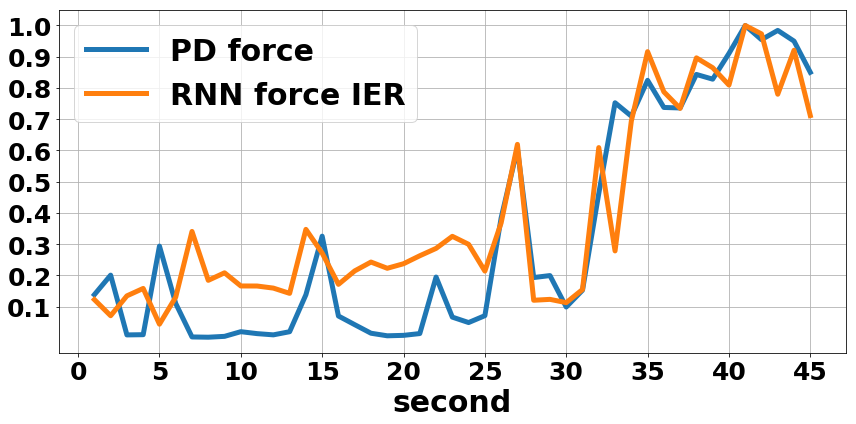

none -0.22323480394680284


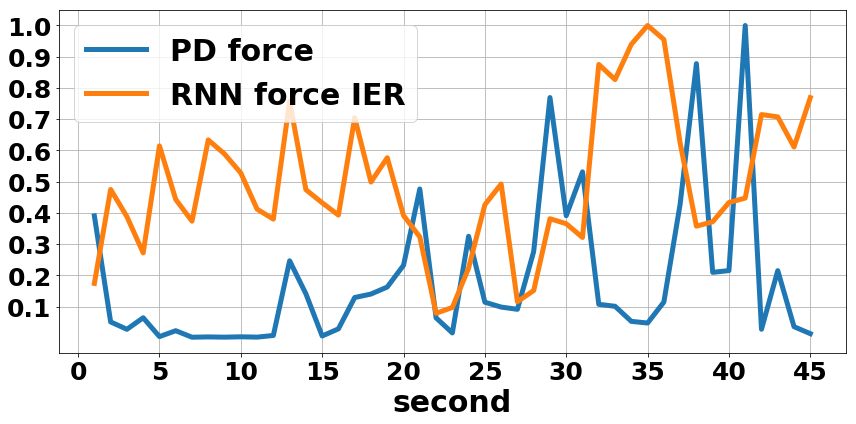

A 0.3702389303857625


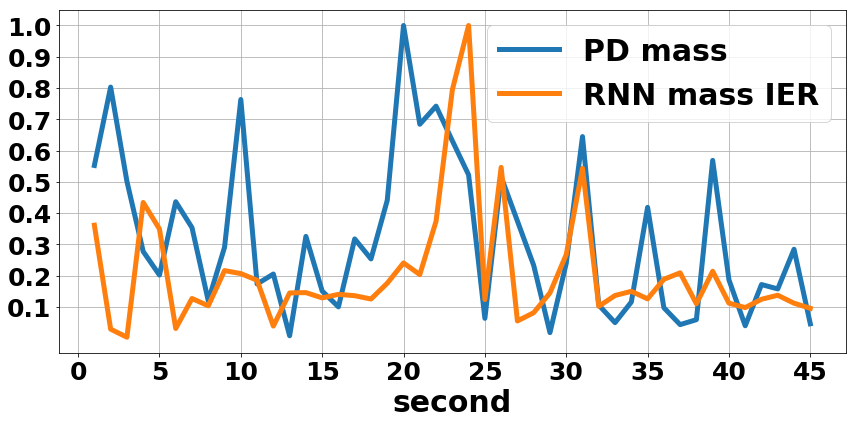

same -0.4791580597446529


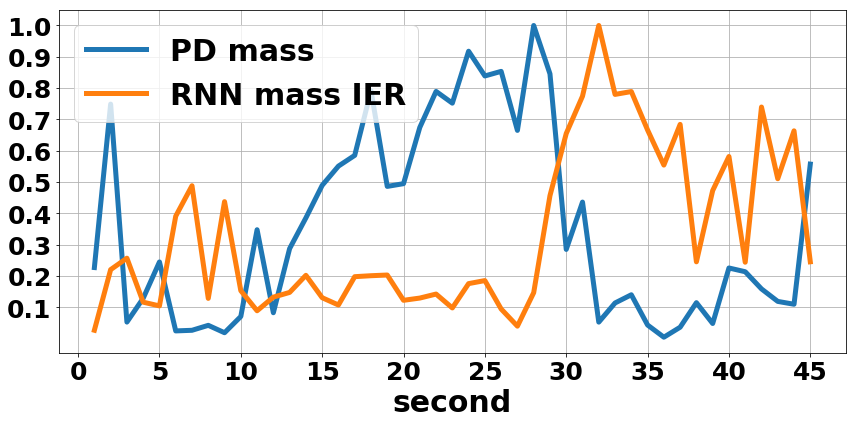

In [31]:
_ = plot_information_curves_and_get_display(clips, correlation_dfs, "force", 0)
plt.tick_params(axis="both", labelsize=25)
plt.tight_layout()
plt.savefig("cogsci_images/force_PD_RNN_good_example.pdf")
plt.savefig("cogsci_images/force_PD_RNN_good_example.jpg")

plt.show()

_ = plot_information_curves_and_get_display(clips, correlation_dfs, "force", -1)
plt.tick_params(axis="both", labelsize=25)
plt.tight_layout()
plt.savefig("cogsci_images/force_PD_RNN_bad_example.pdf")
plt.savefig("cogsci_images/force_PD_RNN_bad_example.jpg")

plt.show()

_ = plot_information_curves_and_get_display(clips, correlation_dfs, "mass", 0)
plt.tick_params(axis="both", labelsize=25)
plt.tight_layout()
plt.savefig("cogsci_images/mass_PD_RNN_good_example.pdf")
plt.savefig("cogsci_images/mass_PD_RNN_good_example.jpg")

plt.show()

_ = plot_information_curves_and_get_display(clips, correlation_dfs, "mass", -1)
plt.tick_params(axis="both", labelsize=25)
plt.tight_layout()
plt.savefig("cogsci_images/mass_PD_RNN_bad_example.pdf")
plt.savefig("cogsci_images/mass_PD_RNN_bad_example.jpg")

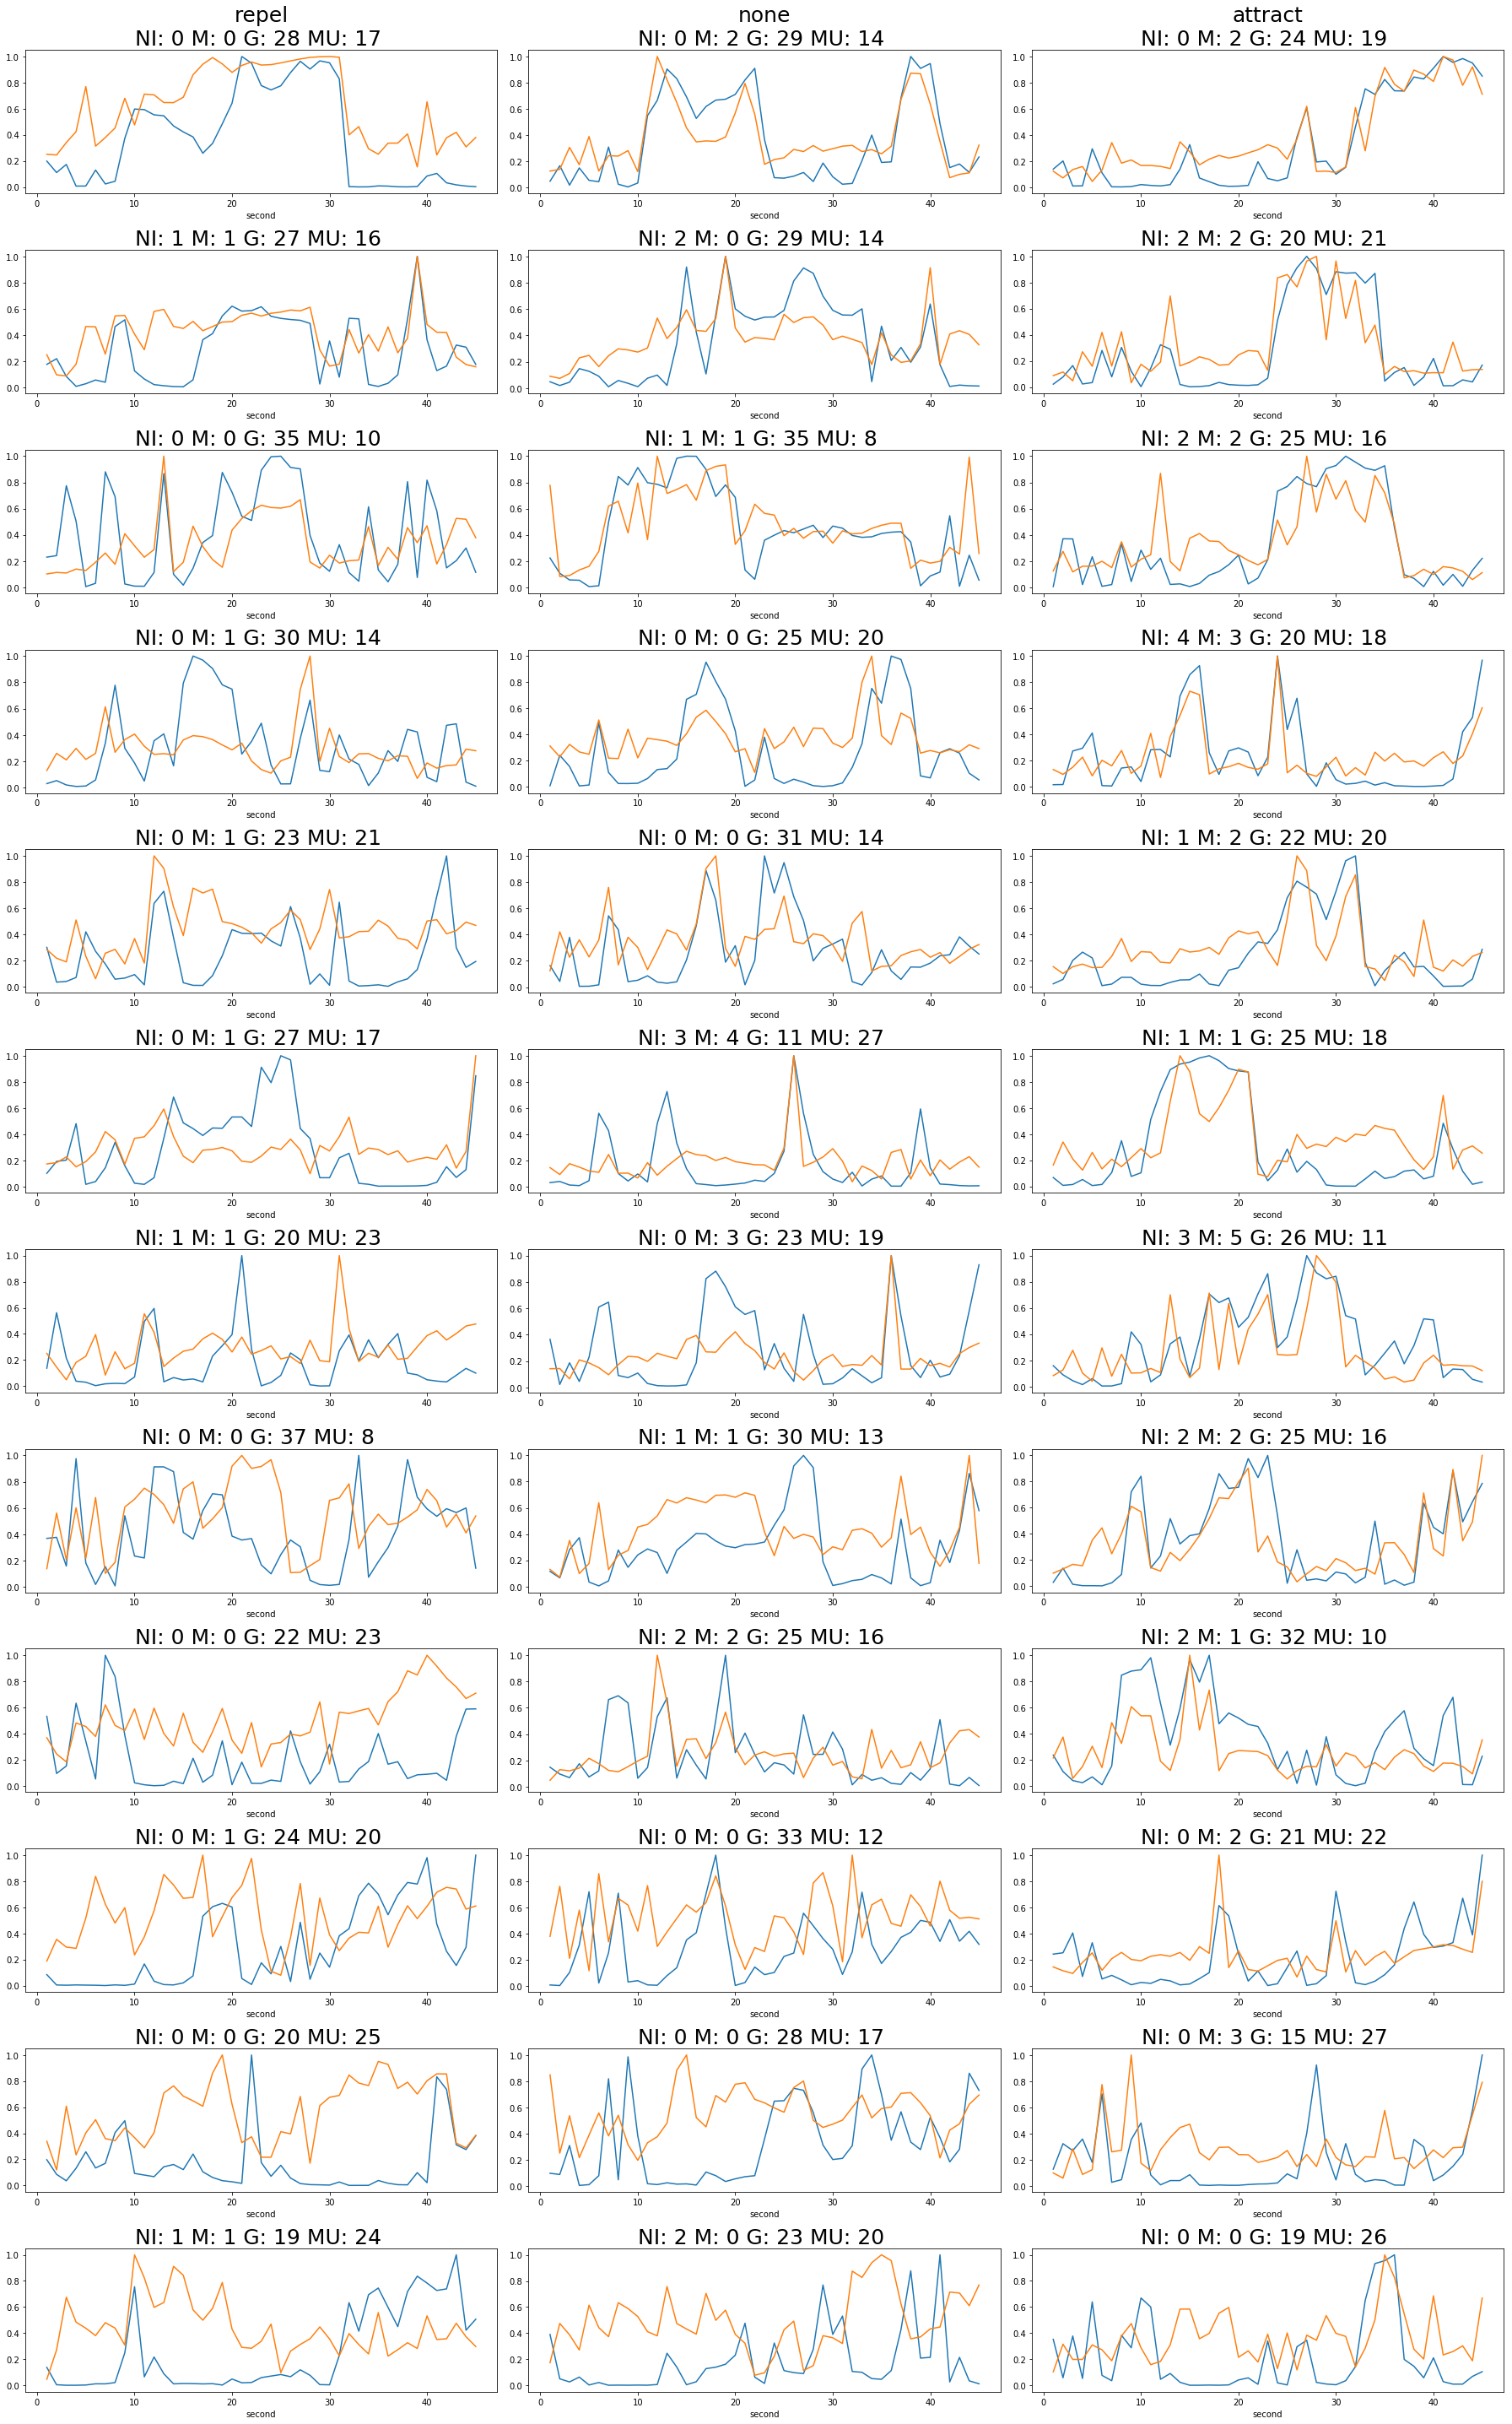

In [32]:
nrows = 12
ncols = 36 // nrows

f, axis = plt.subplots(nrows, ncols, figsize=(25, 40))

question_type = "force"

correlation_dfs = sorted(correlation_dfs, key=lambda x: (x.true_rel, x[question_type+"_corr"].unique()[0]), reverse=True)

# a_ratios = []
# b_ratios = []

missed = []
made_up = []
no_information = []
got_it = []
evidence_threshold = 0.1

for i, df in enumerate(correlation_dfs):
        
    row = i // nrows
    col = i % nrows
        
    trial_missed = len(df[(df.pd_force >= evidence_threshold) & (df.force_entropy_reduction < evidence_threshold)])    
    trial_made_up = len(df[(df.pd_force < evidence_threshold) & (df.force_entropy_reduction >= evidence_threshold)])
    trial_got_it = len(df[(df.pd_force >= evidence_threshold) & (df.force_entropy_reduction >= evidence_threshold)])
    trial_no_info = len(df[(df.pd_force < evidence_threshold) & (df.force_entropy_reduction < evidence_threshold)])
                        
    missed.append(trial_missed)
    made_up.append(trial_made_up)
    got_it.append(trial_got_it)
    no_information.append(trial_no_info)

    title = "NI: %d M: %d G: %d MU: %d " % (trial_no_info, trial_missed, trial_got_it, trial_made_up)
    if col == 0:
        title = df.true_rel + "\n" + title
    
    axis[col][row].set_title(title, fontsize=25)
    df["pd_"+question_type].plot(ax=axis[col][row])
    df[question_type+"_entropy_reduction"].plot(ax=axis[col][row])

plt.tight_layout()
plt.savefig("cogsci_images/all_PD_IER_force_plots.pdf")
plt.savefig("cogsci_images/all_PD_IER_force_plots.jpg")

In [33]:
for name, arr in zip(["Missed", "Made up", "Got it", "No information"], [missed, made_up, got_it, no_information]):
    print(name, np.mean(arr) / 0.45, np.std(arr) / 0.45)

Missed 2.7777777777777777 2.7404904790645817
Made up 39.25925925925926 11.294778282945854
Got it 56.04938271604938 12.37404149464279
No information 1.9135802469135803 2.40898966680097


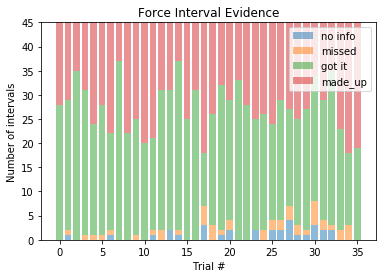

In [34]:
force_missed = np.array(missed)
force_made_up = np.array(made_up)
force_got_it = np.array(got_it)
force_no_information = np.array(no_information)

plt.title("Force Interval Evidence")
plt.xlabel("Trial #")
plt.ylabel("Number of intervals")
plt.ylim((0, 45))
plt.bar(np.arange(0, len(force_missed)), force_no_information, label="no info", alpha=0.5)
plt.bar(np.arange(0, len(force_missed)), force_missed, bottom=force_no_information, label="missed", alpha=0.5)
plt.bar(np.arange(0, len(force_missed)), force_got_it, bottom=force_no_information + force_missed, label="got it", alpha=0.5)
plt.bar(np.arange(0, len(force_missed)), force_made_up, bottom=force_no_information + force_got_it + force_missed, label="made_up", alpha=0.5)

plt.legend()
plt.savefig("cogsci_images/force_interval_classification.pdf")
plt.savefig("cogsci_images/force_interval_classification.jpg")

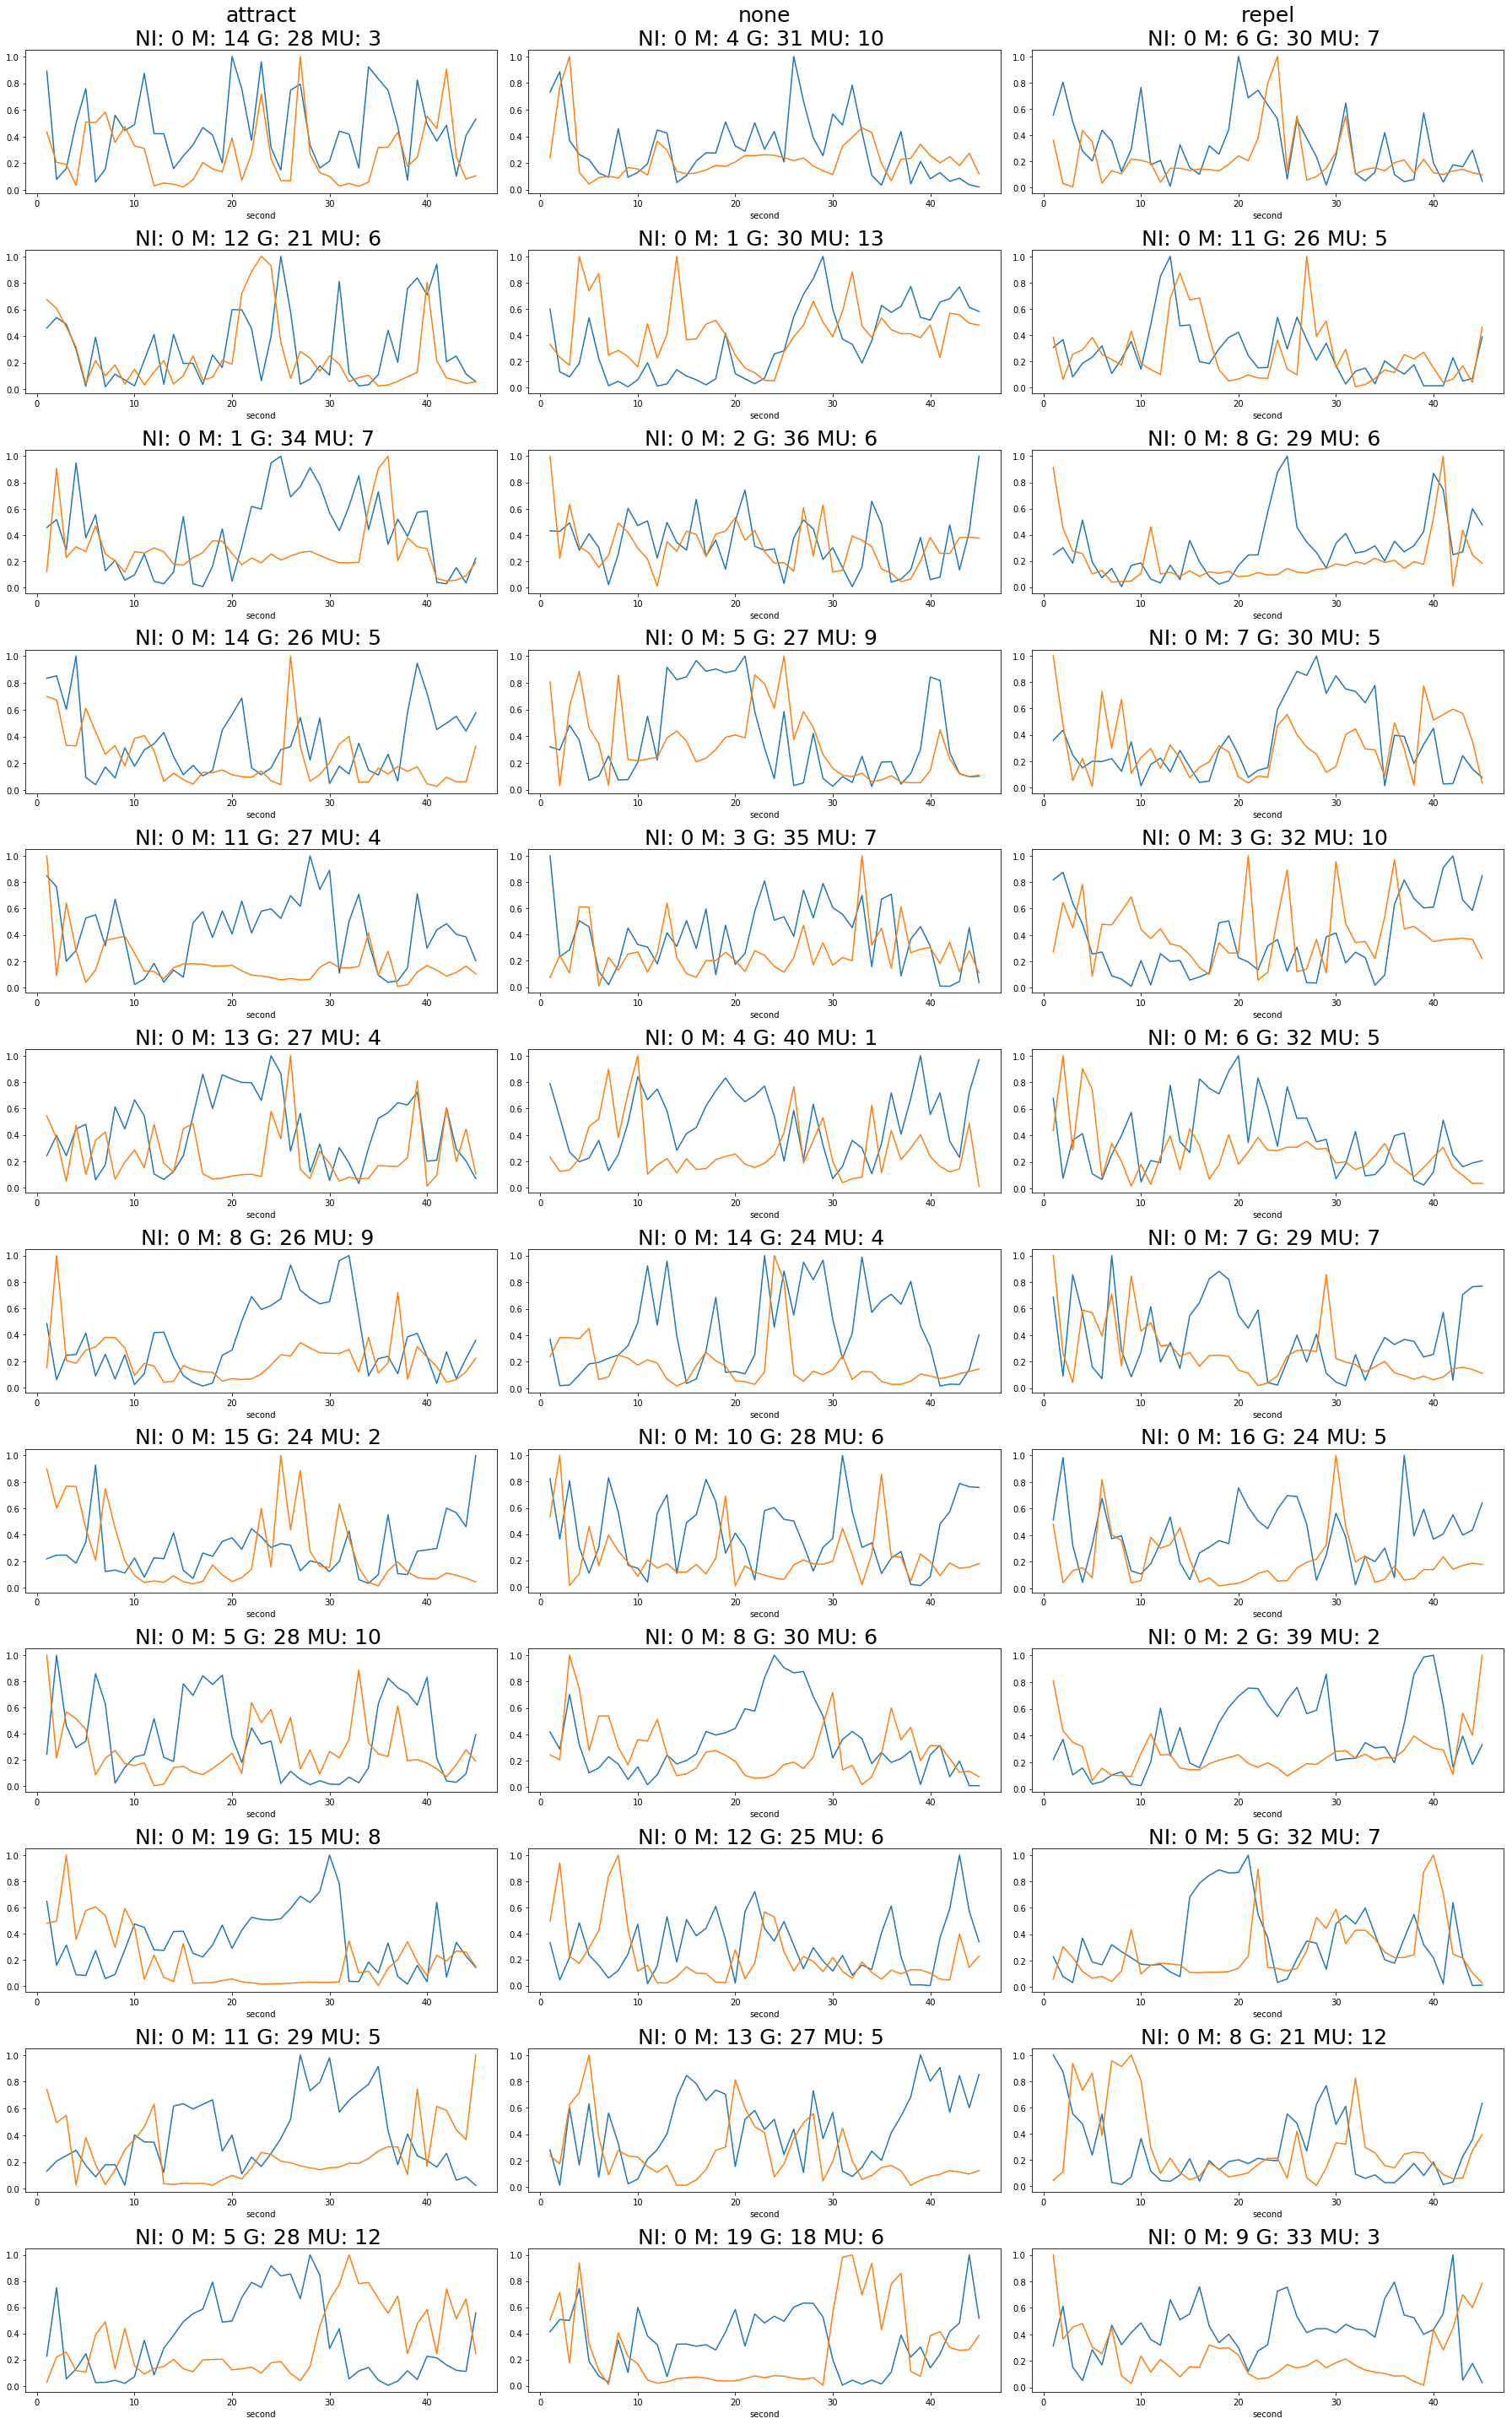

In [35]:
nrows = 12
ncols = 36 // nrows

f, axis = plt.subplots(nrows, ncols, figsize=(25, 40))

question_type = "mass"

correlation_dfs = sorted(correlation_dfs, key=lambda x: (x.true_mass, x[question_type+"_corr"].unique()[0]), reverse=True)

missed = []
made_up = []
no_information = []
got_it = []
evidence_threshold = 0.1

for i, df in enumerate(correlation_dfs):
        
    row = i // nrows
    col = i % nrows
    
    trial_missed = len(df[(df.pd_mass >= evidence_threshold) & (df.mass_entropy_reduction < evidence_threshold)])
    trial_made_up = len(df[(df.pd_mass < evidence_threshold) & (df.mass_entropy_reduction >= evidence_threshold)])
    trial_got_it = len(df[(df.pd_mass >= evidence_threshold) & (df.mass_entropy_reduction >= evidence_threshold)])
    trial_no_information = len(df[(df.pd_mass < evidence_threshold) & (df.mass_entropy_reduction < evidence_threshold)])
    
    missed.append(trial_missed)
    made_up.append(trial_made_up)
    got_it.append(trial_got_it)
    no_information.append(trial_no_information)
    
    title = "NI: %d M: %d G: %d MU: %d " % (trial_no_info, trial_missed, trial_got_it, trial_made_up)
    if col == 0:
        title = df.true_rel + "\n" + title
    
    axis[col][row].set_title(title, fontsize=25)
    df["pd_"+question_type].plot(ax=axis[col][row])
    df[question_type+"_entropy_reduction"].plot(ax=axis[col][row])

plt.tight_layout()
plt.savefig("cogsci_images/all_PD_IER_mass_plots.pdf")
plt.savefig("cogsci_images/all_PD_IER_mass_plots.jpg")

In [36]:
for name, arr in zip(["Missed", "Made up", "Got it", "No information"], [missed, made_up, got_it, no_information]):
    print(name, np.mean(arr) / 0.45, np.std(arr) / 0.45)

Missed 19.19753086419753 10.863320671684658
Made up 14.074074074074073 6.263531305662134
Got it 63.02469135802469 11.4174171785127
No information 3.7037037037037037 3.3126932999996885


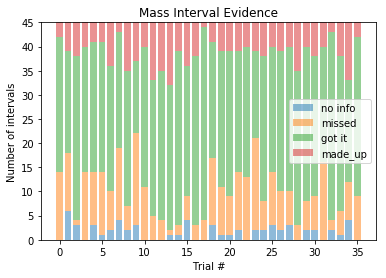

In [37]:
mass_missed = np.array(missed)
mass_made_up = np.array(made_up)
mass_got_it = np.array(got_it)
mass_no_information = np.array(no_information)

plt.title("Mass Interval Evidence")
plt.xlabel("Trial #")
plt.ylabel("Number of intervals")
plt.ylim((0, 45))
plt.bar(np.arange(0, len(mass_missed)), mass_no_information, label="no info", alpha=0.5)
plt.bar(np.arange(0, len(mass_missed)), mass_missed, bottom=mass_no_information, label="missed", alpha=0.5)
plt.bar(np.arange(0, len(mass_missed)), mass_got_it, bottom=mass_no_information + mass_missed, label="got it", alpha=0.5)
plt.bar(np.arange(0, len(mass_missed)), made_up, bottom=mass_no_information + mass_got_it + mass_missed, label="made_up", alpha=0.5)

plt.legend()
plt.savefig("cogsci_images/mass_interval_classification.pdf")
plt.savefig("cogsci_images/mass_interval_classification.jpg")

In [38]:
from scipy.stats import ttest_ind

print(ttest_ind(force_missed, mass_missed))
print(ttest_ind(force_made_up, mass_made_up))
print(ttest_ind(force_got_it, mass_got_it))
print(ttest_ind(force_no_information, mass_no_information))

Ttest_indResult(statistic=-8.670430819211651, pvalue=1.0650510679477019e-12)
Ttest_indResult(statistic=11.536555173151037, pvalue=7.510470297136075e-18)
Ttest_indResult(statistic=-2.450984651347263, pvalue=0.016747175996560414)
Ttest_indResult(statistic=-2.585578199627909, pvalue=0.011805411259165042)
